# Finetune EfficientNet-B2


## efficientnetb2_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb2_1080repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b2(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\profi/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 39.8MB/s]


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 260x260, suitable for EfficientNet-B2
    transforms.Resize((260, 260)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_18824\2647021809.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s, Loss=0.21938632428646088, Elapsed=32.5061s, ETA=0.0000s] 


Epoch 1 completed in 139.9789s
Train Loss: 0.934622981127976 - Train Accuracy: 60.50745121096311
Validation Loss: 0.7796437905232112 - Validation Accuracy: 67.52849303503588

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.41it/s, Loss=0.21642735600471497, Elapsed=32.7917s, ETA=0.0000s] 


Epoch 2 completed in 141.9586s
Train Loss: 0.6734451730816351 - Train Accuracy: 71.76906899436919
Validation Loss: 0.6722368776798249 - Validation Accuracy: 72.20346137610805

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s, Loss=0.028423281386494637, Elapsed=32.8856s, ETA=0.0000s]


Epoch 3 completed in 143.2981s
Train Loss: 0.5615921807771473 - Train Accuracy: 76.59483051039099
Validation Loss: 0.667338691179951 - Validation Accuracy: 75.17940059096665

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.36it/s, Loss=0.06817532330751419, Elapsed=33.0416s, ETA=0.0000s] 


Epoch 4 completed in 144.8980s
Train Loss: 0.48276374863751365 - Train Accuracy: 79.83989507247688
Validation Loss: 0.7294058856368065 - Validation Accuracy: 75.87589700295483

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.36it/s, Loss=0.002473961329087615, Elapsed=32.9751s, ETA=0.0000s]


Epoch 5 completed in 143.3253s
Train Loss: 0.42286417344746563 - Train Accuracy: 82.39298071052215
Validation Loss: 0.731868399924909 - Validation Accuracy: 74.24018573237653

EarlyStopping counter: 2/5
Epoch 6/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.35it/s, Loss=0.181205153465271, Elapsed=33.1216s, ETA=0.0000s]   


Epoch 6 completed in 146.6927s
Train Loss: 0.3477643629632933 - Train Accuracy: 85.10662354989711
Validation Loss: 0.7044599926471711 - Validation Accuracy: 77.20557197129591

EarlyStopping counter: 3/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.32it/s, Loss=0.010184920392930508, Elapsed=33.3039s, ETA=0.0000s]


Epoch 7 completed in 144.8045s
Train Loss: 0.2926867767910048 - Train Accuracy: 87.12150335813301
Validation Loss: 0.7832653197521965 - Validation Accuracy: 77.40607851414099

EarlyStopping counter: 4/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:22<00:00,  3.32it/s, Loss=0.037098538130521774, Elapsed=33.2221s, ETA=0.0000s]

Epoch 8 completed in 145.1386s
Train Loss: 0.25747100263834 - Train Accuracy: 88.40822233780331
Validation Loss: 0.815798427015543 - Validation Accuracy: 77.28999577880963

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


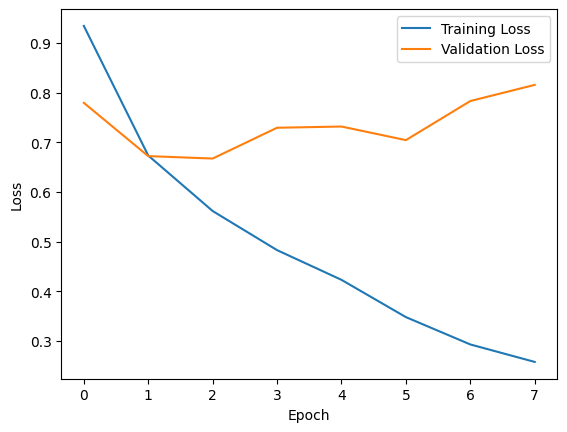

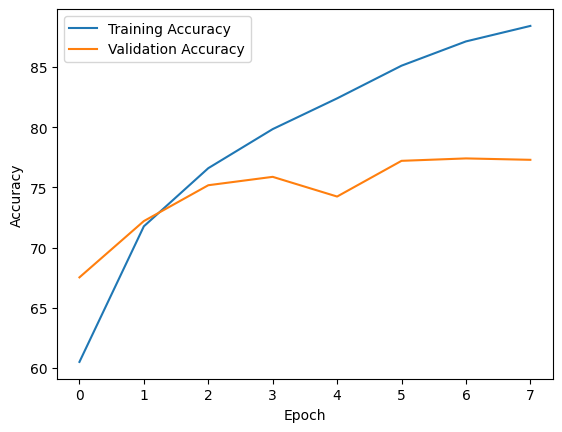

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]

Test Accuracy: 0.7719
Test Precision: 0.7821
Test Recall: 0.7719
Test F1-score: 0.7725

              precision    recall  f1-score   support

       Anger       0.69      0.83      0.76       916
       Bored       0.79      0.93      0.85      1098
     Disgust       0.49      0.63      0.55       291
        Fear       0.51      0.61      0.56       308
       Happy       0.86      0.71      0.78      1914
     Neutral       0.79      0.69      0.74      2226
    Question       0.92      0.92      0.92      1139
         Sad       0.79      0.73      0.76       857
    Surprise       0.67      0.79      0.73       728

    accuracy                           0.77      9477
   macro avg       0.72      0.76      0.74      9477
weighted avg       0.78      0.77      0.77      9477



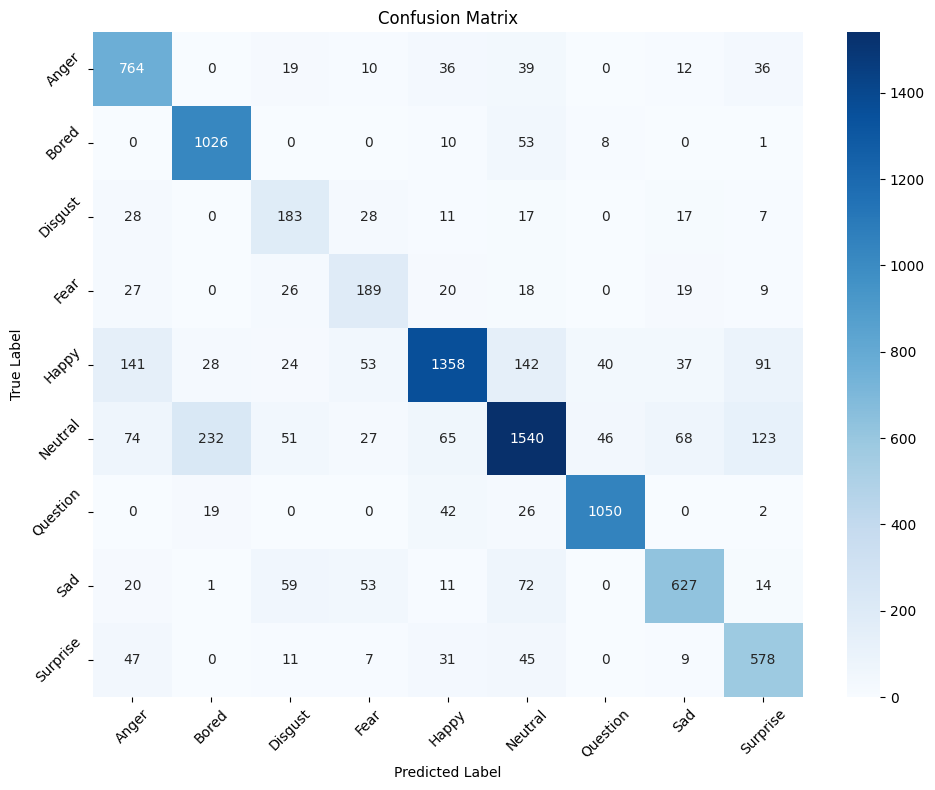

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)